In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
pip install mahotas

Note: you may need to restart the kernel to use updated packages.


In [65]:
import cv2
import mahotas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

print(os.listdir("../input/"))

['ckplus']


In [66]:
print(os.listdir("../input/ckplus/"))

['ck', 'CK+48']


In [67]:
print(os.listdir("../input/ckplus/CK+48/"))

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']


In [68]:
data_path = "/kaggle/input/ckplus/CK+48"

In [69]:
# Read images and labels
images = []
labels = []

# Iterate through each emotion folder
for emotion_folder in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion_folder)
    
    # Iterate through each image in the folder
    for file_name in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        images.append(image)
        labels.append(emotion_folder)


In [70]:
print("Number of images loaded:", len(images))
print("Unique labels:", np.unique(labels))

Number of images loaded: 981
Unique labels: ['anger' 'contempt' 'disgust' 'fear' 'happy' 'sadness' 'surprise']


In [71]:
# Haralick feature extraction
def extract_haralick_features(image):
    features = mahotas.features.haralick(image).mean(axis=0)
    return features

In [72]:
# For all images
haralick_features = [extract_haralick_features(image) for image in images]

In [73]:
# Convert the features to array
X = np.array(haralick_features)

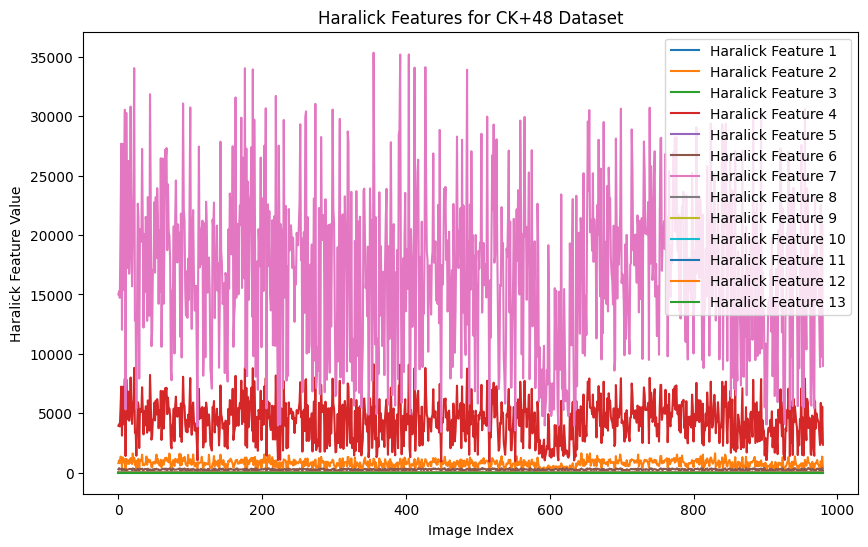

In [74]:
# Plot Haralick features using a line plot for entire dataset
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(X.shape[1]):
    ax.plot(X[:, i], label=f"Haralick Feature {i + 1}")

ax.set_xlabel("Image Index")
ax.set_ylabel("Haralick Feature Value")
ax.set_title("Haralick Features for CK+48 Dataset")
ax.legend()
plt.show()

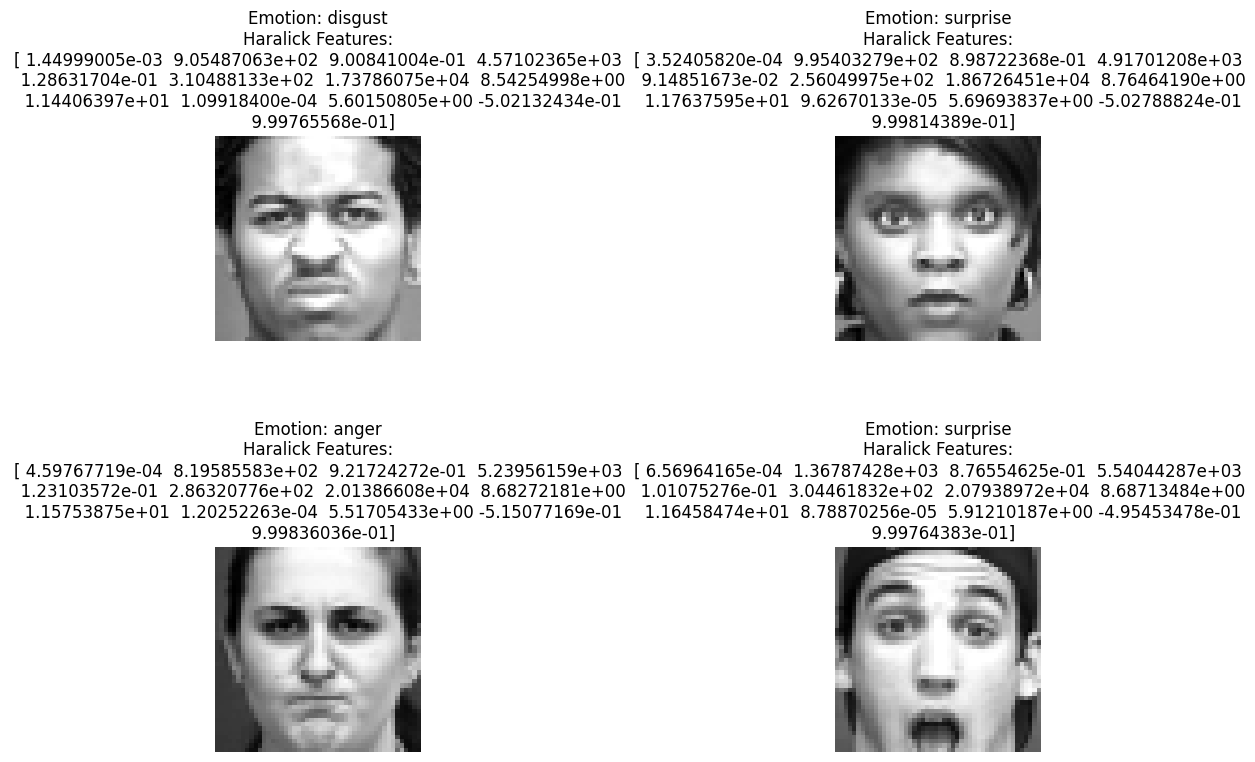

In [75]:
# Display images with their haralick features
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  
fig.subplots_adjust(hspace=1, wspace=1)  

axs = axs.flatten()

for i in range(4):
    index = np.random.randint(len(X))
    image = images[index]
    haralick_feature_values = X[index]

    axs[i].imshow(image, cmap="gray")
    axs[i].set_title(f"Emotion: {labels[index]}\nHaralick Features:\n{haralick_feature_values}")
    axs[i].axis("off")

plt.show()


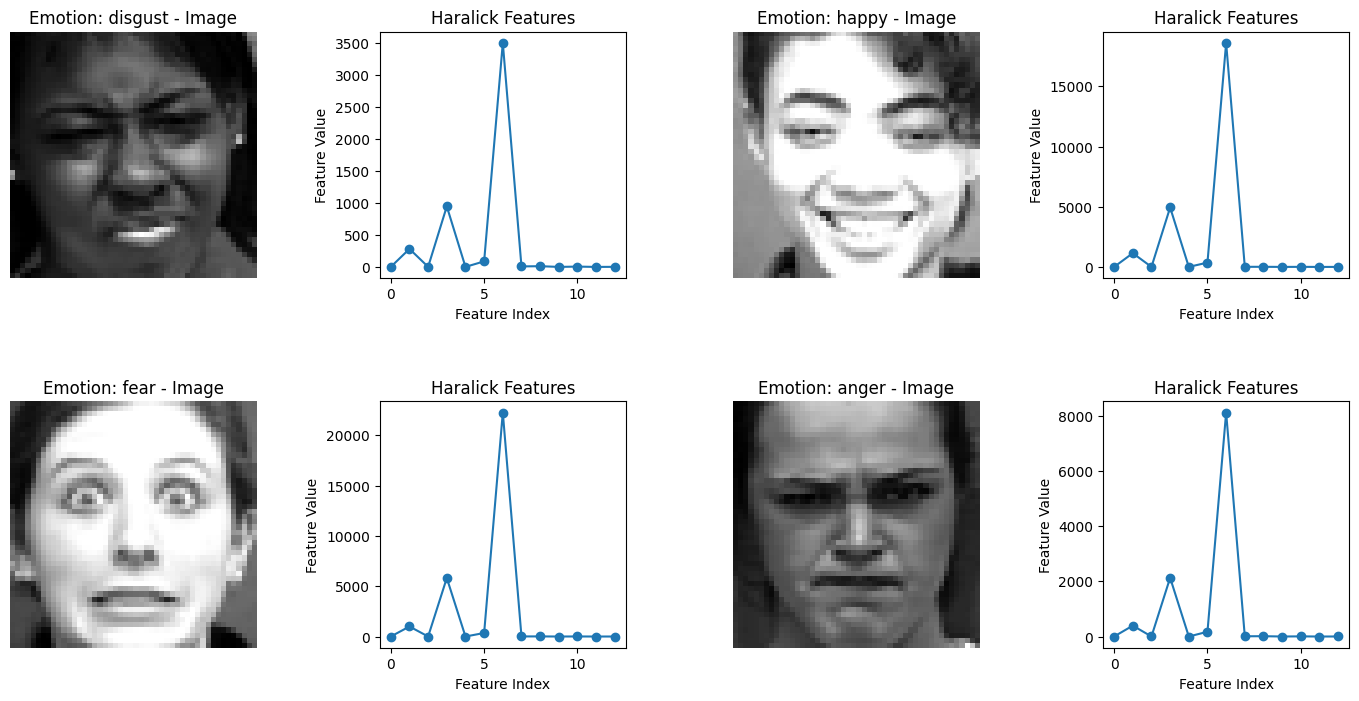

In [76]:
# Display image and line plot for Haralick features
fig, axs = plt.subplots(2, 2, figsize=(16, 8))  
fig.subplots_adjust(wspace=0.4, hspace=0.5)  

for i in range(2):
    for j in range(2):
        index = np.random.randint(len(X))
        image = images[index]
        haralick_feature_values = X[index]

        axs[i, j].imshow(image, cmap="gray")
        axs[i, j].set_title(f"Emotion: {labels[index]} - Image")
        axs[i, j].axis("off")

        ax_line = axs[i, j].inset_axes([1.5, 0, 1, 1])
        ax_line.plot(haralick_feature_values, marker='o')
        ax_line.set_title("Haralick Features")
        ax_line.set_xlabel("Feature Index")
        ax_line.set_ylabel("Feature Value")

plt.show()

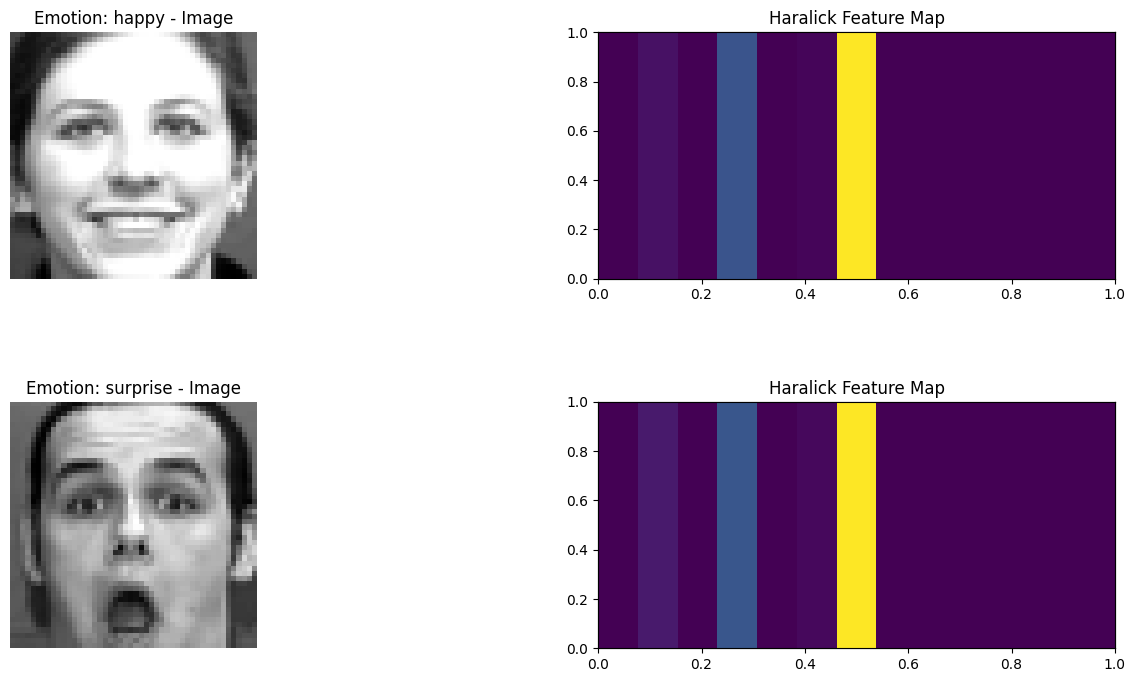

In [77]:
# Display images with their Haralick feature maps
fig, axs = plt.subplots(2, 2, figsize=(16, 8))  
fig.subplots_adjust(wspace=0.4, hspace=0.5)  

for i in range(2):
    index = np.random.randint(len(X))
    image = images[index]
    haralick_feature_values = X[index]

    
    axs[i, 0].imshow(image, cmap="gray")
    axs[i, 0].set_title(f"Emotion: {labels[index]} - Image")
    axs[i, 0].axis("off")

    
    ax_haralick = axs[i, 1].inset_axes([0, 0, 1, 1])
    ax_haralick.pcolormesh(haralick_feature_values.reshape(1, -1), cmap='viridis', vmin=haralick_feature_values.min(), vmax=haralick_feature_values.max())
    ax_haralick.set_title("Haralick Feature Map")
    ax_haralick.set_xticks([])
    ax_haralick.set_yticks([])

plt.show()

In [78]:
# Function to load and preprocess data
def load_data(data_path):
    images = []
    labels = []

    for emotion_folder in os.listdir(data_path):
        emotion_path = os.path.join(data_path, emotion_folder)

        for file_name in os.listdir(emotion_path):
            file_path = os.path.join(emotion_path, file_name)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            images.append(image)
            labels.append(emotion_folder)

    images, labels = shuffle(images, labels, random_state=42)

    # Convert labels to integers
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    return np.array(images), np.array(labels)


In [79]:
# Load data
images, labels = load_data(data_path)

In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [81]:
# Model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 classes for CK+48 dataset


In [82]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 128)        

In [84]:
# Reshape the data for CNN input
X_train = X_train.reshape((-1, 48, 48, 1))
X_test = X_test.reshape((-1, 48, 48, 1))


In [85]:
# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0


In [86]:
# Train the model
hist=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
25/25 [==============================] - 3s 64ms/step - loss: 1.8315 - accuracy: 0.2398 - val_loss: 1.7681 - val_accuracy: 0.2690
Epoch 2/10
25/25 [==============================] - 1s 54ms/step - loss: 1.6626 - accuracy: 0.4018 - val_loss: 1.3884 - val_accuracy: 0.5888
Epoch 3/10
25/25 [==============================] - 1s 57ms/step - loss: 1.1382 - accuracy: 0.5906 - val_loss: 0.8695 - val_accuracy: 0.6954
Epoch 4/10
25/25 [==============================] - 1s 55ms/step - loss: 0.7229 - accuracy: 0.7500 - val_loss: 0.5921 - val_accuracy: 0.7665
Epoch 5/10
25/25 [==============================] - 1s 56ms/step - loss: 0.6159 - accuracy: 0.7640 - val_loss: 0.5512 - val_accuracy: 0.7563
Epoch 6/10
25/25 [==============================] - 1s 57ms/step - loss: 0.4235 - accuracy: 0.8431 - val_loss: 0.3922 - val_accuracy: 0.8122
Epoch 7/10
25/25 [==============================] - 1s 55ms/step - loss: 0.3309 - accuracy: 0.8916 - val_loss: 0.2908 - val_accuracy: 0.9239
Epoch 8/10
25

In [87]:
# Evaluate the model on the test data
score = model.evaluate(X_test, y_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 17ms/step - loss: 0.1869 - accuracy: 0.9391
Test Loss: 0.18687936663627625
Test accuracy: 0.9390863180160522


In [88]:
history=hist.history

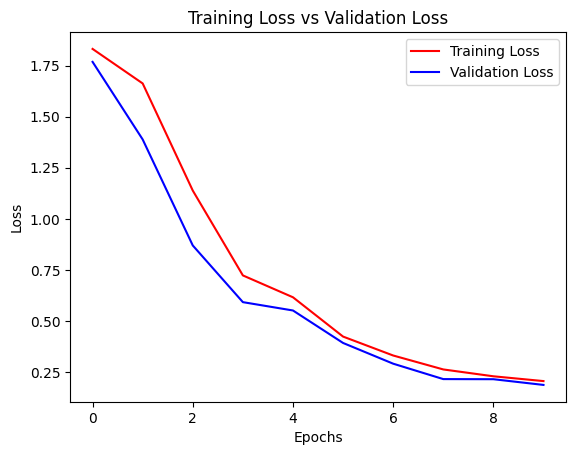

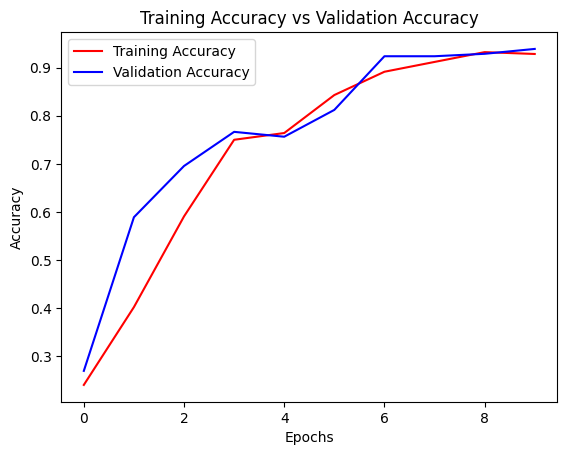

In [89]:
# Visualizing Training and Validation Loss
%matplotlib inline

train_loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(train_loss))

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizing Training and Validation Accuracy
train_acc = history['accuracy']
val_acc = history['val_accuracy']

plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [90]:
# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

7/7 [==============================] - 0s 14ms/step


In [91]:
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)



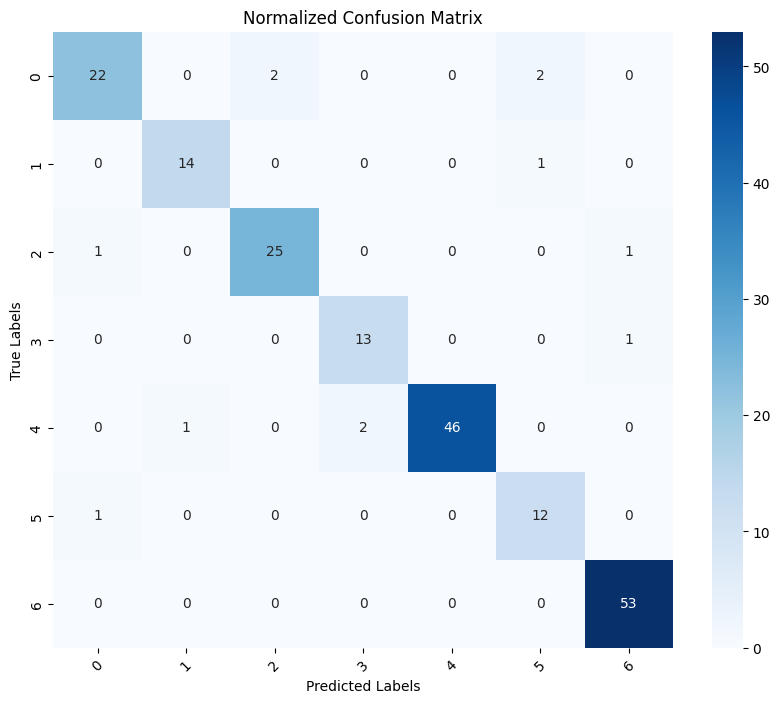

In [92]:

import seaborn as sns
# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(conf_mat, annot=True, cmap="Blues")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Normalized Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

In [93]:
# Display classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        26
           1       0.93      0.93      0.93        15
           2       0.93      0.93      0.93        27
           3       0.87      0.93      0.90        14
           4       1.00      0.94      0.97        49
           5       0.80      0.92      0.86        13
           6       0.96      1.00      0.98        53

    accuracy                           0.94       197
   macro avg       0.92      0.93      0.92       197
weighted avg       0.94      0.94      0.94       197



In [94]:
def process_ck(data_path):
    # Create a directory to save output for each emotion
    output_dir = "/kaggle/working/haralick_output"
    os.makedirs(output_dir, exist_ok=True)
 
    # Read images and labels
    images = []
    labels = []

    # Iterate through each emotion folder
    for emotion_folder in os.listdir(data_path):
        emotion_path = os.path.join(data_path, emotion_folder)
        
        # Create a subdirectory for each emotion
        emotion_output_dir = os.path.join(output_dir, emotion_folder)
        os.makedirs(emotion_output_dir, exist_ok=True)

        # Iterate through each image in the folder
        for file_name in os.listdir(emotion_path):
            file_path = os.path.join(emotion_path, file_name)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            images.append(image)
            labels.append(emotion_folder)

        # Haralick feature extraction for all images
        haralick_features = [extract_haralick_features(image) for image in images]
        X = np.array(haralick_features)

        # Display images with their Haralick feature maps and line plots
        for i in range(len(X)):
            image = images[i]
            haralick_feature_values = X[i]

            # line plot
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))

            # Display the image on the first subplot
            ax[0].imshow(image, cmap="gray")
            ax[0].set_title("Image")
            ax[0].axis("off") 
            
            ax[1].plot(haralick_feature_values, marker='o')
            ax[1].set_title("Haralick Features")
            ax[1].set_xlabel("Feature Index")
            ax[1].set_ylabel("Feature Value")
            plt.savefig(os.path.join(emotion_output_dir, f"image_and_line_plot_{i}.png"))
            plt.close()

            #Haralick feature map
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].imshow(image, cmap="gray")
            axs[0].set_title("Image")
            axs[0].axis("off")

            axs[1].imshow(haralick_feature_values.reshape(1, -1), cmap='viridis', vmin=haralick_feature_values.min(), vmax=haralick_feature_values.max())
            axs[1].set_title("Haralick Feature Map")
            axs[1].axis("off")

            plt.savefig(os.path.join(emotion_output_dir, f"image_and_map_{i}.png"))
            plt.close()

    print("Processing completed. Output saved in:", output_dir)


process_ck(data_path)

Processing completed. Output saved in: /kaggle/working/haralick_output
